# Init

In [4]:
import os, sys

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

config = "bruz"
if config == "ur1":
    sys.path.insert(0, "../")
    siepelDir = "C:/Users/pleroy/Documents/CAMILL/SER/WR15_v2"
elif config == "bruz":
    sys.path.insert(0, "/home/pleroy/DEV/DIADEM")
    siepelDir = "/home/pleroy/DATA/CAMILL/WR15_v2"

import toolsdiadem.tools as dia
import toolsdiadem.ser as ser
from toolsdiadem.Probe import Probe
from toolsdiadem.ConfigSer2 import ConfigSer2

In [5]:
#%matplotlib qt5
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
cmap='jet'
conf = ConfigSer2(os.path.join(siepelDir, "wr10.ini"))
conf.printConfig()
dataShape = (conf.sup.nb_elev, conf.sup.nb_freq)

/home/pleroy/DATA/CAMILL/WR15_v2/wr10.ini
base_path (path to the ini file): /home/pleroy/DATA/CAMILL/WR15_v2
out_path (for the processing outputs): /home/pleroy/DATA/CAMILL/WR15_v2/processing/wr10
gateWidth 500.0
gateCenter 6450.0
centerFreq 92.5
bandWidth 17.4
idxElevation 21
vmin -90.0
vmax -40.0

SUPPORT
nb_elev 41
nb_freq 2801
nb_ssb 4
el0 0.65
az0 -0.44

REFERENCE
nb_elev 41
nb_freq 2801
nb_ssb 4
el0 0.275
az0 -0.44


# Données de la sonde

In [8]:
probe = Probe(os.path.join(conf.base_path, "20200707/S11FDC_WR10.s1p"))
probe_interpolation = interpolate.interp1d(probe.freq, probe.S11)

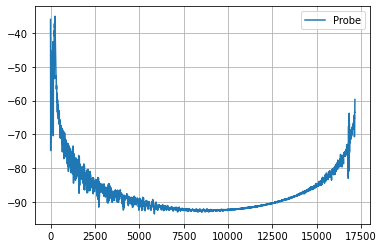

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(probe.d, ser.dB(np.fft.ifft(probe.S11)), label=f"Probe" )
ax.legend()
ax.grid()

# Données des plaques

## Référence

In [12]:
dir_ref = f"{conf.base_path}/20200707/031_plaqueRef"
freq_reference, S11_reference = ser.getData_ssb(
    conf.ref.nb_elev, conf.ref.nb_freq, conf.ref.nb_ssb, dir_ref, tag="WR10_")

In [14]:
probe_S11_interp = probe_interpolation(freq_reference)
d = np.linspace(0, 300 / (freq_reference[1] - freq_reference[0]), conf.ref.nb_freq) * 0.5;

In [15]:
S11_reference_compensated = S11_reference - probe_S11_interp

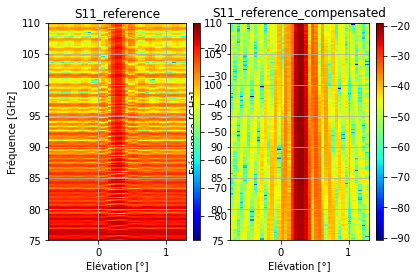

In [18]:
fig, (ax0, ax1) = plt.subplots(1,2)

im = ax0.pcolormesh(conf.ref.elevation, freq_reference, ser.dB(S11_reference).T, cmap=cmap, shading='auto')
title = f"S11_reference"
ax0.set_title(title)
ax0.set_xlabel( "Elévation [°]" )
ax0.set_ylabel( "Fréquence [GHz]" )
dia.addColorBar(  im, ax0, aspect='auto' )

im = ax1.pcolormesh(conf.ref.elevation, freq_reference, ser.dB(S11_reference_compensated).T, cmap=cmap, shading='auto')
title = f"S11_reference_compensated"
ax1.set_title(title)
ax1.set_xlabel( "Elévation [°]" )
ax1.set_ylabel( "Fréquence [GHz]" )
dia.addColorBar(  im, ax1, aspect='auto' )

## Support

In [20]:
dir_support = f"{conf.base_path}/20200709/035_plaqueSupport"
freq_support, S11_support = ser.getData_ssb(
    conf.sup.nb_elev, conf.sup.nb_freq, conf.sup.nb_ssb, dir_support, tag="WR10_")

In [21]:
S11_support_compensated = S11_support - probe_S11_interp

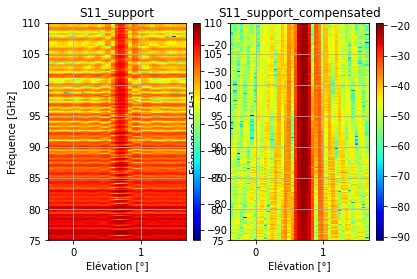

In [23]:
fig, (ax0, ax1) = plt.subplots(1,2)

im = ax0.pcolormesh(conf.sup.elevation, freq_support, ser.dB(S11_support).T, cmap=cmap, shading='auto')
title = f"S11_support"
ax0.set_title(title)
ax0.set_xlabel( "Elévation [°]" )
ax0.set_ylabel( "Fréquence [GHz]" )
dia.addColorBar(  im, ax0, aspect='auto' )

im = ax1.pcolormesh(conf.sup.elevation, freq_support, ser.dB(S11_support_compensated).T, cmap=cmap, shading='auto')
title = f"S11_support_compensated"
ax1.set_title(title)
ax1.set_xlabel( "Elévation [°]" )
ax1.set_ylabel( "Fréquence [GHz]" )
dia.addColorBar(  im, ax1, aspect='auto' )

# Recherche de maximum

## Référence

In [24]:
idx = np.where(abs(d - conf.gateCenter) < conf.gateWidth)[0]

In [26]:
maxVals = np.amax(np.abs(np.fft.ifft(S11_reference, axis=1))[:,idx], axis=1)
maxElev = np.where(maxVals == np.amax(maxVals))
print(f"maxElev = {maxElev}")
iElevRefMax = maxElev[0][0]
print(f"reference elevation at maximum: {conf.ref.elevation[iElevRefMax]:.2f}, index {iElevRefMax}")

maxElev = (array([20]),)
reference elevation at maximum: 0.28, index 20


## Support

In [28]:
maxVals = np.amax(np.abs(np.fft.ifft(S11_support, axis=1))[:,idx], axis=1)
maxElev = np.where(maxVals == np.amax(maxVals))
print(f"maxElev = {maxElev}")
iElevSupportMax = maxElev[0][0]
print(f"support elevation at maximum: {conf.sup.elevation[iElevSupportMax]:.2f}, index {iElevSupportMax}")

maxElev = (array([21]),)
support elevation at maximum: 0.70, index 21


## Plot

In [29]:
reference_max = S11_reference[iElevRefMax,:]
support_max = S11_support[iElevSupportMax,:]
referenceComp_max = S11_reference_compensated[iElevRefMax,:]
supportComp_max = S11_support_compensated[iElevSupportMax,:]

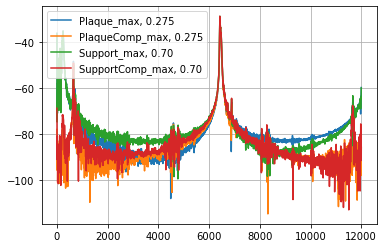

In [31]:
fig, ax = plt.subplots(1,1)
ax.plot(d, ser.dB(np.fft.ifft(reference_max)), label=f"Plaque_max, {conf.ref.elevation[iElevRefMax]}")
ax.plot(d, ser.dB(np.fft.ifft(referenceComp_max)), label=f"PlaqueComp_max, {conf.ref.elevation[iElevRefMax]}")
ax.plot(d, ser.dB(np.fft.ifft(support_max)), label=f"Support_max, {conf.sup.elevation[iElevSupportMax]:.2f}")
ax.plot(d, ser.dB(np.fft.ifft(supportComp_max)), label=f"SupportComp_max, {conf.sup.elevation[iElevSupportMax]:.2f}")
ax.legend()
ax.grid()

# Save data

In [34]:
tmp = np.zeros((conf.ref.nb_freq, 3))
tmp[:,0] = freq_reference
tmp[:,1] = np.real(reference_max)
tmp[:,2] = np.imag(reference_max)
filename = f"{conf.out_path}/data/S11_plaque_ref_from_scan.txt"
print(filename)
np.savetxt(filename, tmp, header="GHz real imag")

/home/pleroy/DATA/CAMILL/WR15_v2/processing/wr10/data/S11_plaque_ref_from_scan.txt


In [36]:
tmp = np.zeros((conf.ref.nb_freq, 3))
tmp[:,0] = freq_reference
tmp[:,1] = np.real(probe_S11_interp)
tmp[:,2] = np.imag(probe_S11_interp)
filename = f"{conf.out_path}/data/S11_probe_interpolated.txt"
print(filename)
np.savetxt(filename, tmp, header="GHz real imag")

/home/pleroy/DATA/CAMILL/WR15_v2/processing/wr10/data/S11_probe_interpolated.txt
